In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-t0vxhrue
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-t0vxhrue


In [ ]:
import tensorflow as tf
import numpy as np
import random
import os
import matplotlib.pyplot as plt

import PIL.Image
import timeit

from glob import glob
import cv2
from tensorflow_examples.models.pix2pix import pix2pix

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## NST

### Preparación

In [ ]:
path_GTA = "/content/drive/MyDrive/GTA/"
path_Reales = "/content/drive/MyDrive/Reales/"
# path_CARLA = "/content/drive/MyDrive/CARLA/"

iter = 20  # Número de imagenes de prueba

list_GTA = os.listdir(path_GTA)
images_GTA = random.choices(list_GTA, k=iter)

# list_CARLA = os.listdir(path_CARLA)
# images_CARLA = random.choices(list_CARLA, k=iter)

list_Reales = os.listdir(path_Reales)
images_Reales = random.choices(list_Reales, k=iter)

for i in range(iter):
  images_GTA[i] = path_GTA + images_GTA[i]
  # images_CARLA[i] = path_CARLA + images_CARLA[i]
  images_Reales[i] = path_Reales + images_Reales[i]

num = 0  # Que imagen escoge

In [ ]:
style_image = PIL.Image.open(images_Reales[num])
content_image = PIL.Image.open(images_GTA[num])
# content_image = PIL.Image.open(images_CARLA[num])

Imsize = 256

content_image = np.asarray(content_image.resize((Imsize,Imsize)))
style_image = np.asarray(style_image.resize((Imsize,Imsize)))

content_image = content_image[:,:,0:3].astype(np.float32)/255
style_image = style_image[:,:,0:3].astype(np.float32)/255

content_image = np.expand_dims(content_image,0)
style_image = np.expand_dims(style_image,0)

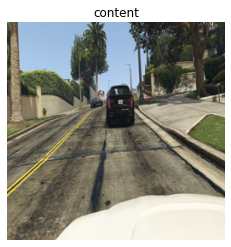

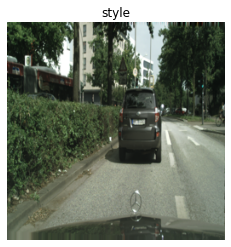

In [ ]:
plt.figure()
plt.imshow(content_image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.title('content')
plt.show()

plt.figure()
plt.imshow(style_image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
plt.title('style')
plt.show()

### Construye el modelo de NST

In [ ]:
STYLE_WEIGHT = 100
CONTENT_WEIGHT = 0.5
Nepochs = 20000
muestra_cada = 200

In [ ]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model


def gram_matrix(input_tensor):
    result = tf.math.reduce_mean(input_tensor, [1,2])
    #input_shape = tf.shape(input_tensor)
    #num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result#/(num_locations)


class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


def style_content_loss(outputs,style_weight,content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    #style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
    #                       for name in style_outputs.keys()])
    #style_loss *= style_weight 

    style_loss = [style_weight*tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()]

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight 
    loss = style_loss + content_loss
    
    return loss, style_loss, content_loss


def clip_0_1(image):
      return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.99, epsilon=1e-1)

style_layers_ori = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

content_layers = ['block5_conv2'] 

### Sacar NST

In [ ]:
for layer in np.arange(1,2):

    style_layers = style_layers_ori[0:5]

    extractor = StyleContentModel(style_layers, content_layers)
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']

    image = tf.Variable(content_image.copy())

    plt.figure()
    plt.imshow(image[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
    plt.show()


    # WEIGHTS FIRST GUESS
    style_weight_FG=5*1e-11
    content_weight_FG=1e-4

    loss, style_loss, content_loss = style_content_loss(extractor(content_image),style_weight_FG,content_weight_FG)
    print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))
    loss_style = np.array(style_loss[0])

    loss, style_loss, content_loss = style_content_loss(extractor(style_image),style_weight_FG,content_weight_FG)
    print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))
    loss_content = np.array(content_loss)

    # WEIGTHS DEFINITION
    style_weight= style_weight_FG * STYLE_WEIGHT/loss_style
    content_weight= content_weight_FG * CONTENT_WEIGHT/loss_content

    # Certify Weights
    loss, style_loss, content_loss = style_content_loss(extractor(content_image),style_weight,content_weight)
    print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))

    loss, style_loss, content_loss = style_content_loss(extractor(style_image),style_weight,content_weight)
    print(np.array(loss[0]), np.array(style_loss[0]), np.array(content_loss))

    @tf.function()  # Precompile
    def train_step(image):
        with tf.GradientTape() as tape:
            outputs = extractor(image)
            loss = style_content_loss(outputs,style_weight,content_weight)

        grad = tape.gradient(loss[1][0], image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

    L_cont = np.array([])
    L_style = np.array([]) 

    start = timeit.default_timer()
    for n in range(0,Nepochs):
        train_step(image)
        
        if np.mod(n,muestra_cada)==0:
            outputs = extractor(image)
            loss, style_loss, content_loss = style_content_loss(outputs,style_weight,content_weight)
            
            L_cont = np.append(L_cont,np.array(content_loss))
            L_style = np.append(L_style,np.array(style_loss[0]))

            print("epoch: ", n, "loss: ", np.array(loss[0]), "style loss: ", np.array(style_loss[0]), "content loss: ", np.array(content_loss))
            
            stop = timeit.default_timer()
            print('Time: ', stop - start)
    
    Output_NST = image

    # RESULTS
    # Curvas
    plt.figure()
    plt.plot(np.log(L_cont))
    plt.plot(np.log(L_style))
    plt.show()

    # Resultados
    plt.figure()
    plt.imshow(Output_NST[0, :,:,:],vmin=0,vmax=1), plt.axis('off')
    # Guardamos el resultado
    plt.savefig('/content/drive/MyDrive/Resultados/Output_NST.png', bbox_inches="tight", pad_inches=0)
    

    # Keep track
    print('style_weight: ' + str(style_weight) + ' content_weight: ' + str(content_weight))
    print(style_layers)

## CycleGAN

### Preparación

In [ ]:
def generator_gta():
    for path in images_GTA:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (286,286))
        yield img

dataset_gta = tf.data.Dataset.from_generator(
    generator_gta,
    output_signature=(
        tf.TensorSpec((286, 286, 3), tf.int32)
    )
)

In [ ]:
def generator_cityscapes():
    for path in images_Reales:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (286,286))
        yield img

dataset_cityscapes = tf.data.Dataset.from_generator(
    generator_cityscapes,
    output_signature=(
        tf.TensorSpec((286, 286, 3), tf.int32)
    )
)

In [ ]:
def preprocess_imgs(img):
    ## Convertimos las imágenes de int a float
    img = tf.cast(img, tf.float32)

    ## Normalizamos al rango [-1,1]
    img = (img/127.5) - 1

    ## Extraemos recortes aleatorios de 256x256
    img = tf.image.random_crop(img, size=[256, 256, 3])

    return img

In [ ]:
dataset_gta_rdy = dataset_gta.map(preprocess_imgs)
dataset_cityscapes_rdy = dataset_cityscapes.map(preprocess_imgs)

dataset_full = tf.data.Dataset.zip((dataset_gta_rdy, dataset_cityscapes_rdy))

In [ ]:
def renormalize(img, contrast=1):
    return img*0.5*contrast + 0.5

### Carga de la GAN

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)


generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./Checkpoints/"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


### Sacar GAN

In [ ]:
for img_gta, img_cs in dataset_full.batch(1):
    break

In [ ]:
ckpt.restore('/content/drive/MyDrive/CycleGTA/ckpt-6')
print ('Latest checkpoint restored!!')
Output_GAN_6 = generator_g.predict(img_gta)

ckpt.restore('/content/drive/MyDrive/CycleGTA/ckpt-10')
print ('Latest checkpoint restored!!')
Output_GAN_10 = generator_g.predict(img_gta)

ckpt.restore('/content/drive/MyDrive/CycleGTA/ckpt-12')
print ('Latest checkpoint restored!!')
Output_GAN_12 = generator_g.predict(img_gta)


Latest checkpoint restored!!


1/1 [==============================] - 1s 1s/step
Latest checkpoint restored!!
1/1 [==============================] - 0s 477ms/step
Latest checkpoint restored!!
1/1 [==============================] - 0s 471ms/step


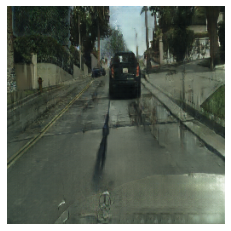

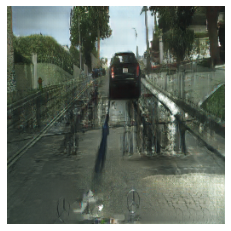

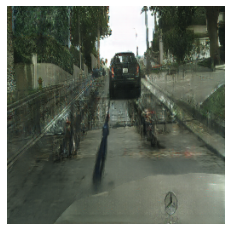

In [ ]:
# Guardamos los resultados
fig, axes = plt.subplots(1,1)
plt.imshow(renormalize(Output_GAN_6.squeeze())), plt.axis('off')
plt.savefig('/content/drive/MyDrive/Resultados/Output_GAN_6.png', bbox_inches="tight", pad_inches=0)

fig, axes = plt.subplots(1,1)
plt.imshow(renormalize(Output_GAN_10.squeeze())), plt.axis('off')
plt.savefig('/content/drive/MyDrive/Resultados/Output_GAN_10.png', bbox_inches="tight", pad_inches=0)

fig, axes = plt.subplots(1,1)
plt.imshow(renormalize(Output_GAN_12.squeeze())), plt.axis('off')
plt.savefig('/content/drive/MyDrive/Resultados/Output_GAN_12.png', bbox_inches="tight", pad_inches=0)

## Final

### Funciones

In [ ]:
def one_hot_mask(y):
    ''' Do the one hot encoding for the masks.
  
    Arguments:
        - y (tf tensor): Mask of shape (height, width, 3)

    Returns:
        - mask (tf tensor): Mask after do the one hot. Shape (height, width, num_classes) '''

    one_hot_map = []
    for color in colors:
        class_map = tf.reduce_all(tf.equal(y, color), axis = -1)
        one_hot_map.append(class_map)
    mask = tf.cast(tf.stack(one_hot_map, axis = -1), tf.int32)
    return mask


def load_image(folder, file, height = 96, width = 256, crop = False):
    ''' Load and preprocess a train image by:
        - Crop the image to not have the Mercedes-Benz star
        - Resize the image to (height, width)
        - Normalize the image to [0, 1]
  
    Arguments:
        - folder (string): Path to the folder
        - file (string): Name of the file to load
        - height (int): Height to resize -- 96
        - width (int): Width to resize -- 256
        - crop (bool): Crpo the image or not -- True

    Returns:
        - image (tf tensor): Preprocessed image '''

    # Load the image (png)
    image = tf.io.read_file(folder + '/' + file)
    image = tf.cast(tf.image.decode_png(image, channels = 3), tf.float32)

    # Crop the image
    if crop:
        image = tf.image.crop_to_bounding_box(image, 0, 0, 768, 2048)

    # Resize the image
    image = tf.image.resize(image, (height, width))

    # Normalize the image
    image = tf.cast(image, tf.float32)/255.0
    return image


def load_mask(folder, file, height = 96, width = 256, one_hot = True, crop = False):
    ''' Load and preprocess a train mask by:
        - Crop the image to not have the Mercedes-Benz star
        - Resize the image to (height, width)
        - Reshaping the mask from (height, width, 3) to (height, width, 30): One hot encoding
  
    Arguments:
        - folder (string): Path to the folder
        - file (string): Name of the file to load
        - height (int): Height to resize -- 96
        - width (int): Width to resize -- 256
        - one_hot (bool): Do one hot encoding or not -- True
        - crop (bool): Crpo the image or not -- True

    Returns:
        - image (tf tensor): Preprocessed mask '''

    # Load the mask (png)
    image = tf.io.read_file(folder + '/' + file)
    image = tf.cast(tf.image.decode_png(image, channels = 3), tf.int32)

    # Crop the mask
    if crop:
        image = tf.image.crop_to_bounding_box(image, 0, 0, 768, 2048)

    # Resize the mask
    image = tf.image.resize(image, (height, width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # One hot encoding
    if one_hot:
        image = one_hot_mask(image)
    return image


def one_hot_to_color_mask(mask, colors, img_height = 96, img_width = 256):
    ''' Convert from the mask from the classes with highest probablities to the correct color. From (96, 256, 1) to (96, 256, 3).
  
    Arguments:
        - mask (tf tensor): Mask with the classes with highest probabilities
        - colors (list): List with the class colors
        - img_height (int): Height of the images -- 96
        - img_width (int): Width of the images -- 256

    Returns:
        - color_mask (tf tensor): Color mask '''

    color_mask = np.zeros((img_height, img_width, channels)).astype('float')
    for c in range(len(colors)):
        color_true = mask == c
        for i in range(3):
            color_mask[:,:,i] += color_true*colors[c][i]

    color_mask = tf.cast(color_mask, dtype = tf.int32)

    return color_mask

def load_train(image_name, mask_name):
    ''' Load and preprocess a train image and its mask
  
    Arguments:
        - image_name (string): Name of the image to load
        - mask_name (string): Name of the mask to load

    Returns:
        - image (tf tensor): Preprocessed image
        - mask (tf tensor): Preprocessed mask '''

    image = load_image(train_images_folder_path, image_name, img_height, img_width)
    mask = load_mask(train_mask_folder_path, mask_name, img_height, img_width)
    return image, mask

### La magia

In [ ]:
train_images_folder_path = "/content/drive/My Drive" 
train_mask_folder_path = "/content/drive/MyDrive/GTA Segmentacion" 

img_height, img_width, channels = 96, 256, 3

batch_size = 2

colors = np.array([(0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), (102, 102, 156), (190, 153, 153), (180, 165, 180), 
                   (150, 100, 100), (150, 120, 90), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), ( 0, 0, 142), 
                   ( 0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), (119, 11, 32), (0, 0, 142)], dtype = np.int32)

images_name = ["GTA/" + images_GTA[num].split("/")[-1], "Resultados/Output_GAN_6.png", "Resultados/Output_GAN_10.png", "Resultados/Output_GAN_12.png", "Resultados/Output_NST.png"]

mask_names = ((images_GTA[num].split("/")[-1] + " ") * 5).split()

dataset = tf.data.Dataset.from_tensor_slices((images_name, mask_names))
dataset = dataset.map(load_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(batch_size)
print(dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 256, 30), dtype=tf.int32, name=None))>


In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Modelo_segmentacion_UNET/best_model_weights_and_architecture')

predictions = model.predict(dataset, batch_size = 10)
predictions = np.argmax(predictions, axis = 3)

idx = range(len(images_name))
visualize_images = [load_image(train_images_folder_path, images_name[i], img_height, img_width) for i in idx]
visualize_masks = [load_mask(train_mask_folder_path, mask_names[i], img_height, img_width, one_hot = False) for i in idx]
preds = predictions[idx]

3/3 [==============================] - 2s 156ms/step


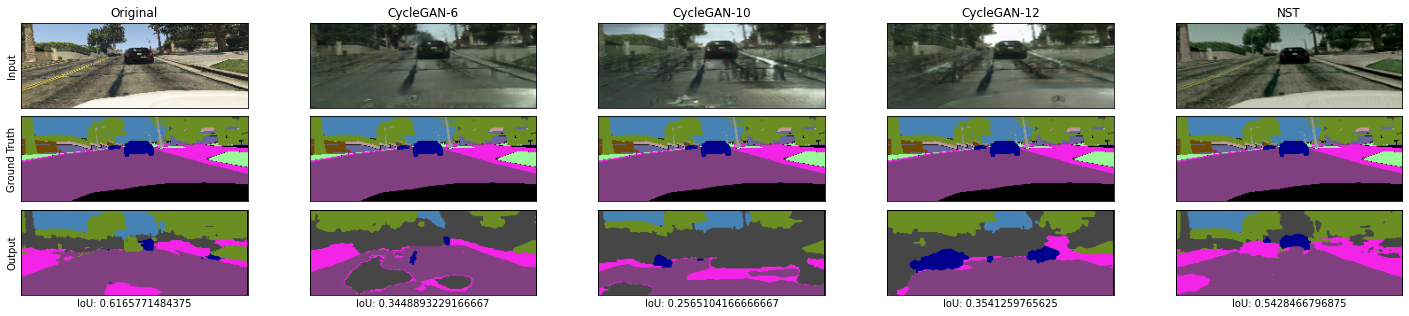

In [ ]:
# Resultados GTA
plt.figure(figsize = (25, 5))
plt.subplots_adjust(hspace = 0.1)

for k in range(5):
    plt.subplot(3, 5, k + 1)
    plt.imshow(visualize_images[k])
    if k==0:
      plt.ylabel("Input")
    plt.title(["Original", "CycleGAN-6", "CycleGAN-10", "CycleGAN-12", "NST"][k])
    plt.yticks(())
    plt.xticks(())

    plt.subplot(3, 5, k + 6)
    plt.imshow(visualize_masks[k])
    if k==0:
      plt.ylabel("Ground Truth")
    plt.yticks(())
    plt.xticks(())

    output = one_hot_to_color_mask(preds[k], colors)
    # IoU calculation
    intersection = 0
    union = img_height * img_width

    for i in range(img_height):
      for j in range(img_width):
        a = visualize_masks[k][i-1,j-1,:] == output[i-1,j-1,:]
        if sum(a.numpy())==3:
          intersection += 1

    iou_score = intersection/union
    
    plt.subplot(3, 5, k + 11)
    plt.imshow(output)
    if k==0:
      plt.ylabel("Output")
    plt.xlabel("IoU: %s" % iou_score)
    plt.yticks(())
    plt.xticks(())

plt.savefig('/content/drive/MyDrive/Resultados/Resultado_GTA.png', bbox_inches="tight", pad_inches=0)

In [ ]:
# # Resultados CARLA
# plt.figure(figsize = (25, 5))
# plt.subplots_adjust(hspace = 0.1)

# for k in range(5):
#     plt.subplot(3, 5, k + 1)
#     plt.imshow(visualize_images[k+5])
#     if k==0:
#       plt.ylabel("Input")
#     plt.title(["Original", "CycleGAN-6", "CycleGAN-10", "CycleGAN-12", "NST"][k])
#     plt.yticks(())
#     plt.xticks(())

#     plt.subplot(3, 5, k + 6)
#     plt.imshow(visualize_masks[k+5])
#     if k==0:
#       plt.ylabel("Ground Truth")
#     plt.yticks(())
#     plt.xticks(())

#     output = one_hot_to_color_mask(preds[k+5], colors)
#     # IoU calculation
#     intersection = np.logical_and(visualize_masks[k+5], output)
#     union = np.logical_or(visualize_masks[k+5], output)
#     iou_score = np.sum(intersection) / np.sum(union)

#     plt.subplot(3, 5, k + 11)
#     plt.imshow(output)
#     if k==0:
#       plt.ylabel("Output")
#     plt.xlabel("IoU: %s" % iou_score)
#     plt.yticks(())
#     plt.xticks(())

# plt.savefig('/content/drive/MyDrive/Resultados/Resultado_CARLA.png', bbox_inches="tight", pad_inches=0)